In [1]:
import pandas as pd
import pandas as pd
import networkx as nx
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import os
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
# Lecture des graphes GEXF
G_day1 = nx.read_gexf('data/sp_data_school_day_1_g.gexf')
G_day2 = nx.read_gexf('data/sp_data_school_day_2_g.gexf')

print("Jour 1 : {} noeuds, {} arêtes".format(G_day1.number_of_nodes(), G_day1.number_of_edges()))
print("Jour 2 : {} noeuds, {} arêtes".format(G_day2.number_of_nodes(), G_day2.number_of_edges()))

Jour 1 : 236 noeuds, 5899 arêtes
Jour 2 : 238 noeuds, 5539 arêtes


In [3]:
import networkx as nx
import pandas as pd

# ----------------------------
# Charger les graphes
# ----------------------------
G_day1 = nx.read_gexf('data/sp_data_school_day_1_g.gexf')
G_day2 = nx.read_gexf('data/sp_data_school_day_2_g.gexf')

# ----------------------------
# Fonction pour calculer les stats par classe
# ----------------------------
def compute_class_stats(G, day_label):
    data = []

    for u, v, d in G.edges(data=True):
        # Attributs des nœuds
        class_u = G.nodes[u].get("class", "Unknown")
        class_v = G.nodes[v].get("class", "Unknown")

        # Poids = durée du contact
        duration = d.get("weight", 0)

        # Ajouter deux lignes : une pour chaque individu
        data.append([day_label, class_u, duration])
        data.append([day_label, class_v, duration])

    df = pd.DataFrame(data, columns=["day", "class", "duration_sec"])

    # Convertir en heures si duration est en secondes
    df["duration_hours"] = df["duration_sec"] / 3600.0

    # Agrégation
    summary = (
        df.groupby(["day", "class"])
          .agg(
              total_duration_hours = ("duration_hours", "sum"),
              number_of_contacts  = ("duration_sec", "count")
          )
          .reset_index()
    )

    return summary

# ----------------------------
# Calculer les stats pour les deux jours
# ----------------------------
stats_day1 = compute_class_stats(G_day1, "Day 1")
stats_day2 = compute_class_stats(G_day2, "Day 2")

# Fusionner
stats = pd.concat([stats_day1, stats_day2], ignore_index=True)

# Affichage
print(stats)

# Export CSV
stats.to_csv("class_contact_stats.csv", index=False)
print("\nFichier exporté : class_contact_stats.csv")


     day    class  total_duration_hours  number_of_contacts
0  Day 1  Unknown                   0.0               11798
1  Day 2  Unknown                   0.0               11078

Fichier exporté : class_contact_stats.csv


In [4]:
import networkx as nx
import pandas as pd

# ----------------------------
# Charger les deux graphes
# ----------------------------
G1 = nx.read_gexf("data/sp_data_school_day_1_g.gexf")
G2 = nx.read_gexf("data/sp_data_school_day_2_g.gexf")  # ⚠ change selon ton fichier réel

# ----------------------------
# Fonction d’agrégation par classe
# ----------------------------
def compute_class_stats(G, day_label):
    rows = []

    for u, v, d in G.edges(data=True):

        # Classe des deux individus
        class_u = G.nodes[u].get("classname", "Unknown")
        class_v = G.nodes[v].get("classname", "Unknown")

        # Durée (secondes) + nombre de contacts
        duration = d.get("duration", 0)
        count = d.get("count", 0)

        # Ajouter une entrée pour chacun des deux individus
        rows.append([day_label, class_u, duration, count])
        rows.append([day_label, class_v, duration, count])

    df = pd.DataFrame(rows, columns=["day", "class", "duration_sec", "contact_count"])

    # Convertir les durées en heures
    df["duration_hours"] = df["duration_sec"] / 3600

    # Agrégation par classe
    summary = (
        df.groupby(["day", "class"])
          .agg(
              total_duration_hours=("duration_hours", "sum"),
              total_contact_events=("contact_count", "sum")
          )
          .reset_index()
    )

    return summary

# ----------------------------
# Calcul des statistiques
# ----------------------------
stats_day1 = compute_class_stats(G1, "Day 1")
stats_day2 = compute_class_stats(G2, "Day 2")

stats = pd.concat([stats_day1, stats_day2], ignore_index=True)

print(stats)

# Export CSV
stats.to_csv("class_contact_stats.csv", index=False)
print("\nStats exportées vers class_contact_stats.csv")


      day     class  total_duration_hours  total_contact_events
0   Day 1        1A             62.288889                  7282
1   Day 1        1B            108.994444                 12058
2   Day 1        2A             47.494444                  5092
3   Day 1        2B             75.166667                  7646
4   Day 1        3A             59.855556                  6877
5   Day 1        3B             72.727778                  7486
6   Day 1        4A             64.233333                  7379
7   Day 1        4B             45.544444                  4999
8   Day 1        5A             53.894444                  6246
9   Day 1        5B             65.933333                  7514
10  Day 1  Teachers             16.311111                  2123
11  Day 2        1A             43.044444                  5398
12  Day 2        1B            120.838889                 12745
13  Day 2        2A             97.594444                 10231
14  Day 2        2B             93.43888

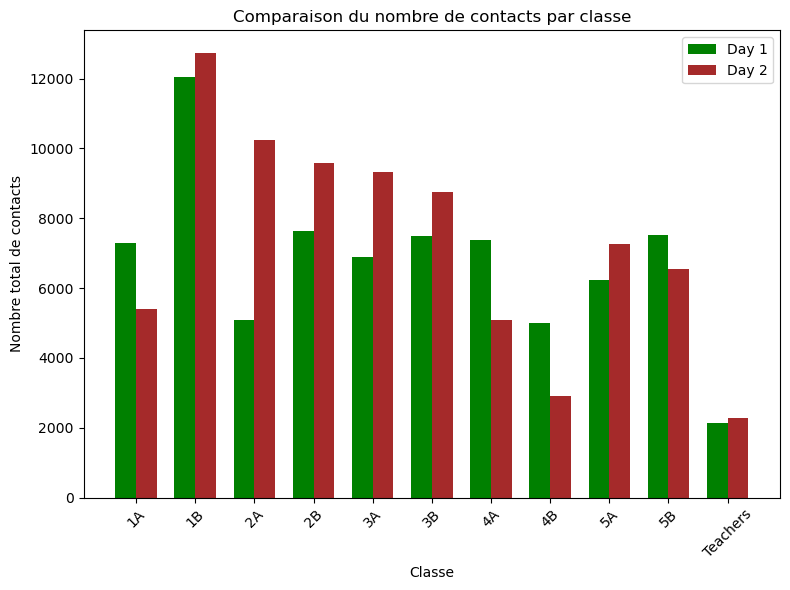

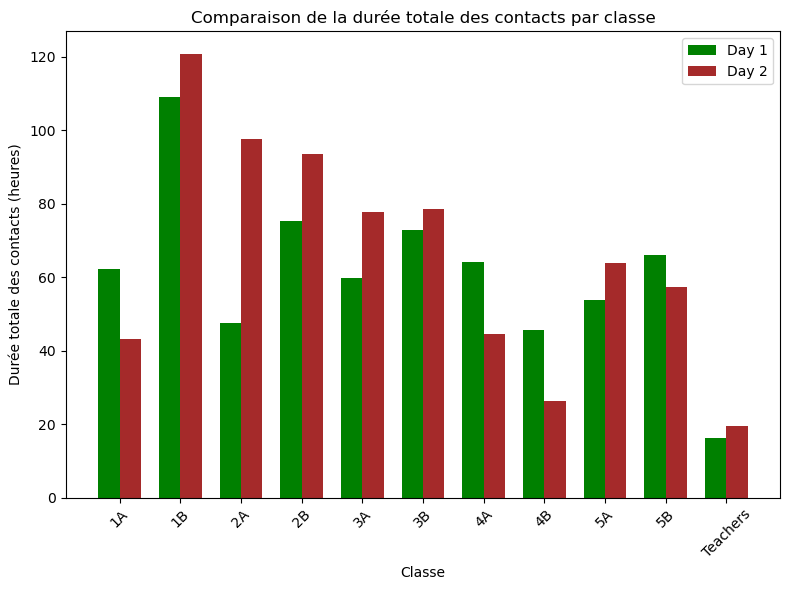

In [5]:
classes = sorted(stats['class'].unique())

# Récupérer les données pour Day 1 et Day 2
day1 = stats[stats['day'] == "Day 1"].set_index('class').reindex(classes, fill_value=0)
day2 = stats[stats['day'] == "Day 2"].set_index('class').reindex(classes, fill_value=0)

# --- Graphique 1 : Nombre de contacts ---
x = np.arange(len(classes))
width = 0.35

plt.figure(figsize=(8,6))
plt.bar(x - width/2, day1['total_contact_events'], width, label='Day 1', color='green')
plt.bar(x + width/2, day2['total_contact_events'], width, label='Day 2', color='brown')

plt.xlabel('Classe')
plt.ylabel('Nombre total de contacts')
plt.title('Comparaison du nombre de contacts par classe')
plt.xticks(x, classes, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# --- Graphique 2 : Durée totale des contacts ---
plt.figure(figsize=(8,6))
plt.bar(x - width/2, day1['total_duration_hours'], width, label='Day 1', color='green')
plt.bar(x + width/2, day2['total_duration_hours'], width, label='Day 2', color='brown')

plt.xlabel('Classe')
plt.ylabel('Durée totale des contacts (heures)')
plt.title('Comparaison de la durée totale des contacts par classe')
plt.xticks(x, classes, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

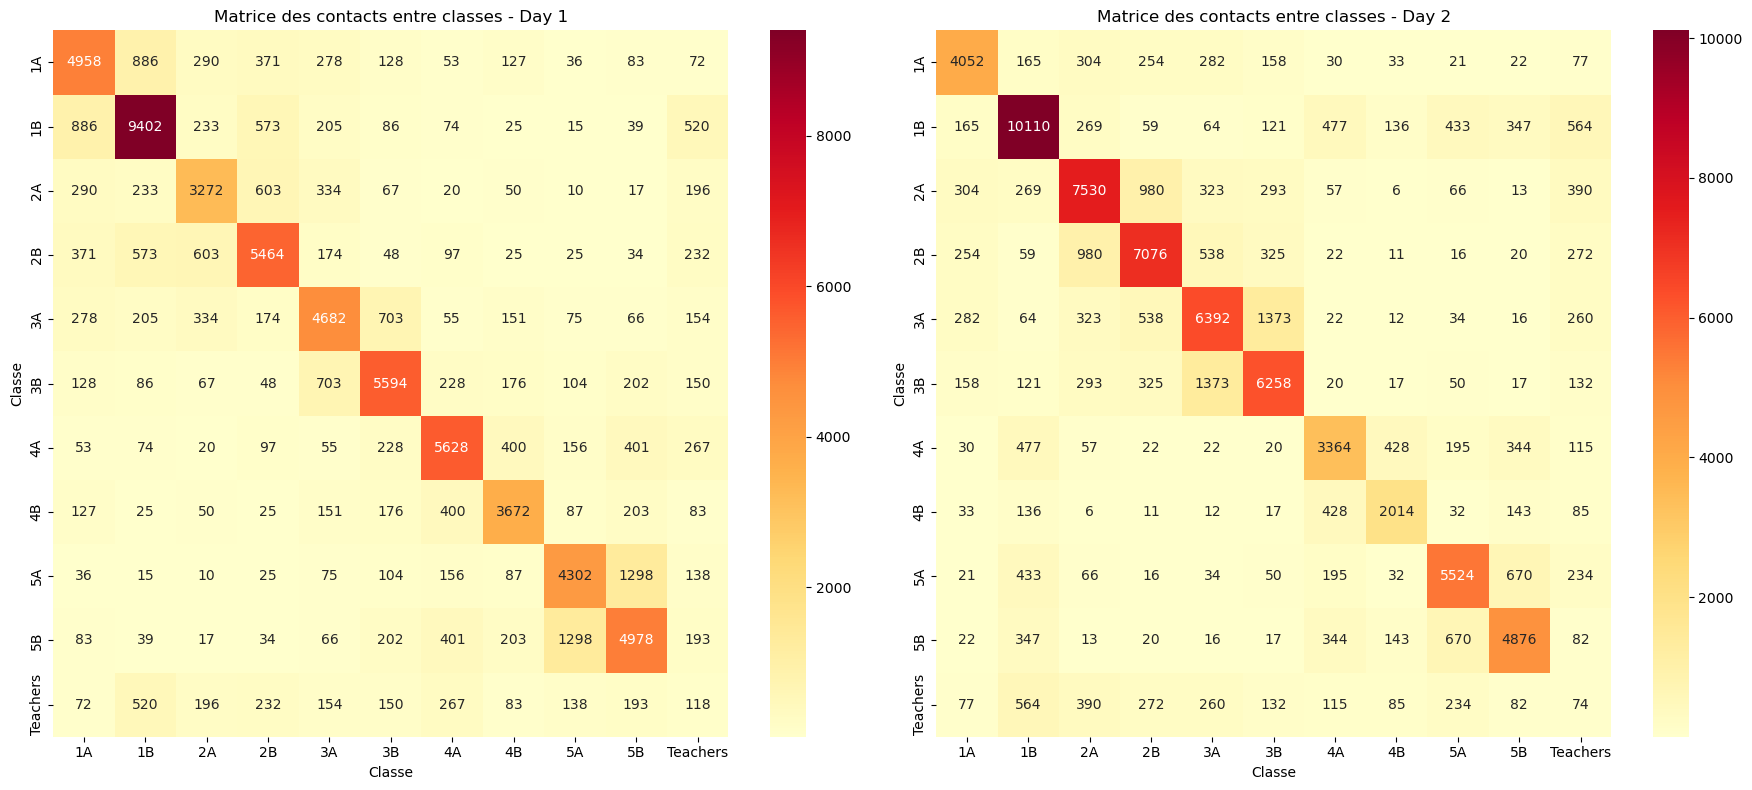

In [6]:
import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

def build_contact_matrix(G, value='count'):
    """
    Crée une matrice de contacts entre classes à partir d'un graphe.
    value : 'count' pour le nombre de contacts, 'duration' pour la durée totale
    """
    # Liste des classes
    classes = sorted({data.get('classname', 'Unknown') for _, data in G.nodes(data=True)})
    
    # Initialiser la matrice
    matrix = pd.DataFrame(0, index=classes, columns=classes)
    
    # Remplir la matrice
    for u, v, d in G.edges(data=True):
        class_u = G.nodes[u].get('classname', 'Unknown')
        class_v = G.nodes[v].get('classname', 'Unknown')
        
        val = d.get(value, 0)
        if value == 'duration':  # convertir en heures si durée
            val = val / 3600
            
        matrix.loc[class_u, class_v] += val
        matrix.loc[class_v, class_u] += val  # symétrique
    
    return matrix

# Construire les matrices pour Day 1 et Day 2
matrix_day1 = build_contact_matrix(G1, value='count')
matrix_day2 = build_contact_matrix(G2, value='count')

# --- Visualisation côte à côte ---
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

sns.heatmap(matrix_day1, annot=True, fmt='g', cmap='YlOrRd', ax=axes[0])
axes[0].set_title('Matrice des contacts entre classes - Day 1')
axes[0].set_xlabel('Classe')
axes[0].set_ylabel('Classe')

sns.heatmap(matrix_day2, annot=True, fmt='g', cmap='YlOrRd', ax=axes[1])
axes[1].set_title('Matrice des contacts entre classes - Day 2')
axes[1].set_xlabel('Classe')
axes[1].set_ylabel('Classe')

plt.tight_layout()
plt.show()


In [7]:
import networkx as nx
import matplotlib.pyplot as plt

# Copier le graphe Day 1 pour ne pas modifier l'original
G_strong = G1.copy()

# Supprimer les arêtes dont la durée est < 120 secondes
edges_to_remove = [(u, v) for u, v, d in G_strong.edges(data=True) if d.get('duration', 0) < 120]
G_strong.remove_edges_from(edges_to_remove)

print(f"Nombre de nœuds : {G_strong.number_of_nodes()}")
print(f"Nombre d'arêtes après filtrage : {G_strong.number_of_edges()}")


Nombre de nœuds : 236
Nombre d'arêtes après filtrage : 1956


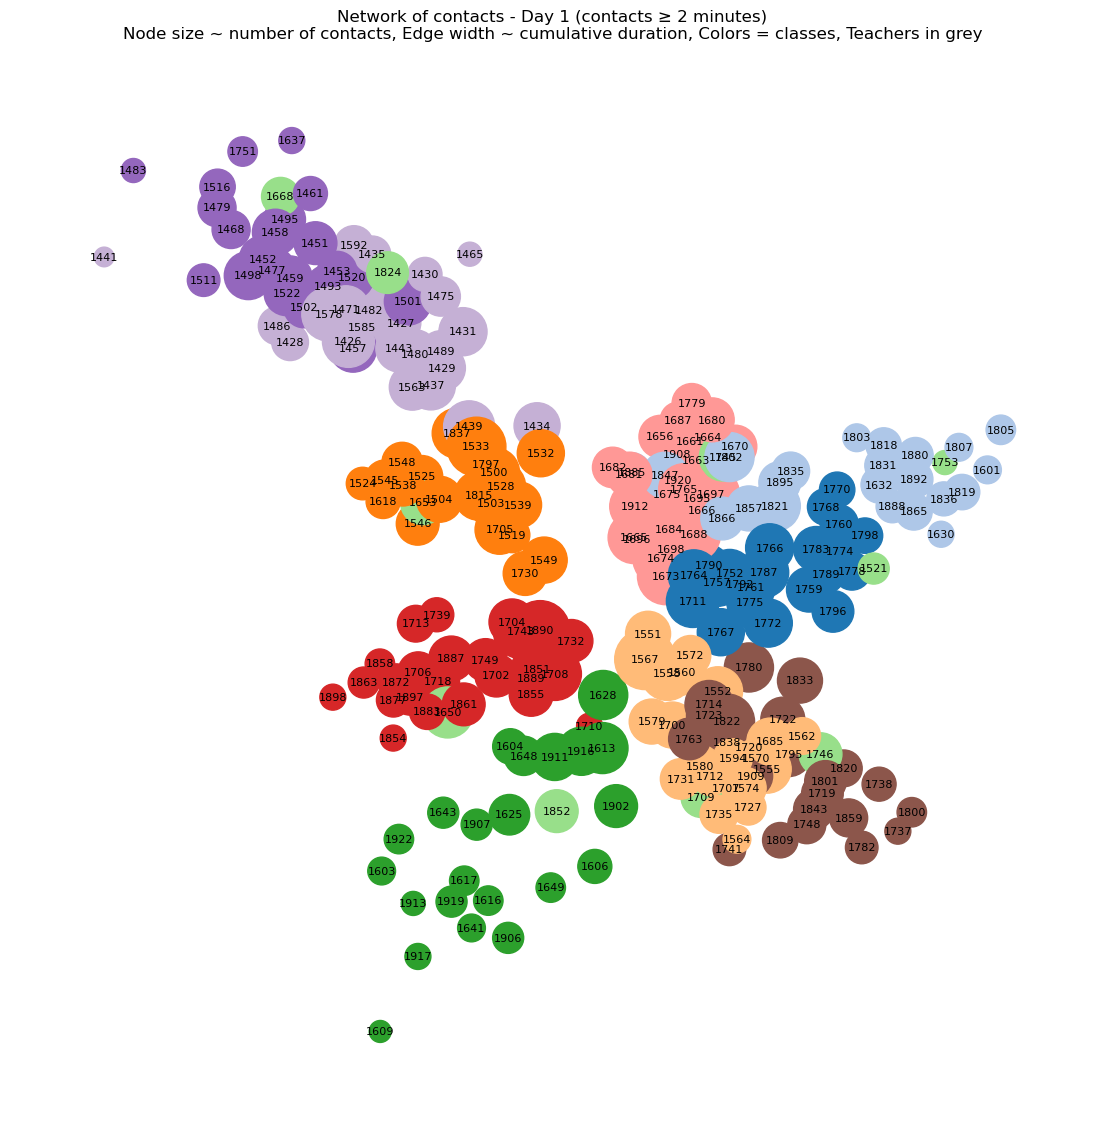

In [ ]:

# Graphe Day 1
G_strong = G1.copy()

# Supprimer les arêtes dont la durée est < 120 secondes
edges_to_remove = [(u, v) for u, v, d in G_strong.edges(data=True) if d.get('duration', 0) < 120]
G_strong.remove_edges_from(edges_to_remove)

# Couleurs des nœuds selon la classe
color_map = {}
classes = set(nx.get_node_attributes(G_strong, 'classname').values())
palette = plt.get_cmap('tab20')

for i, cls in enumerate(classes):
    color_map[cls] = palette(i % 20)

# Assigner les couleurs : enseignants en gris
node_colors = []
for n, data in G_strong.nodes(data=True):
    if data.get('role', 'student') == 'teacher':
        node_colors.append('grey')
    else:
        cls = data.get('classname', 'Unknown')
        node_colors.append(color_map.get(cls, 'lightblue'))

# Taille des nœuds proportionnelle au degré
node_sizes = [100 + 50*G_strong.degree(n) for n in G_strong.nodes()]

# Largeur des arêtes proportionnelle à la durée en minutes
edge_widths = [d.get('duration', 0)/60 for u, v, d in G_strong.edges(data=True)]

# Layout
pos = nx.spring_layout(G_strong, seed=42)

# Dessiner le graphe
plt.figure(figsize=(14, 14))
nx.draw_networkx_nodes(G_strong, pos, node_size=node_sizes, node_color=node_colors)
nx.draw_networkx_edges(G_strong, pos, width=edge_widths, edge_color='white', alpha=0.7)
nx.draw_networkx_labels(G_strong, pos, font_size=8)

plt.title("Network of contacts - Day 1 (contacts ≥ 2 minutes)\nNode size ~ number of contacts, Edge width ~ cumulative duration, Colors = classes, Teachers in grey")
plt.axis('off')
plt.show()
